## Fluctuation test

A question that has emerged a number of times in evolutionary analysis is whether mutation rates vary, and specifically whether they vary in response to a selection pressure. In particular, do mutations emerge as a result of a stressor or do they occur during the growth of the culture? Even more controversially: does the likelihood of an advantageous mutation increase when bacteria are subjected to some stressor (e.g. antibiotic, bacteriophage, etc.)? For a bit of a history of this problem you can consult https://en.wikipedia.org/wiki/Luria%E2%80%93Delbr%C3%BCck_experiment

In the 1940's Salvatore Luria (experimental biologist) and Max Delbrück (physicist) designed an experiment to distinguish whether mutations arose pre or post-stressor. The experiment was the following: bacterial cultures were grown independently from small inocula. After some period of growth, equal volumes of these cultures were plated at low density onto agar containing the T1 phage, so that only resistant bacteria will end up forming small, visible colonies that could be counted. 

What is the expected distribution of the number of resistant bacteria on a plate if the virus **induced** resistance?

What is the expected distribution if the virus **selected** the resistant bacteria from the population that was plated?

Implement a simulation of this experiment: 
- grow populations of bacteria from a single cell to a specified final number
- consider implementing an event-driven simulation, where cell divisions occur and the time to division can be chosen from a variety of distributions when a cell is born
- implement mutations (mutation rate a parameter) at cell division
- implement the phenotype check (resistant/sensitive)
- derive the distribution of the number of mutants per culture
- explore the form of the distribution when mutations are induced or selected
- explore the form of the distribution for different lifespan distributions (what distribution of lifespans did Luria and Delbrück assume in their model?)

In [1]:
import os, sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'population_dynamics'))
from LDSimulationRunner import LDSimulationRunner 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from IPython.display import display, Markdown

## Luria-Delbruck Simulation

Class LDStimulationRunner creates a simulation of an initial population of'bacteria' - which at their core have a lifespan, a mutation rate, time to divide, and survival rate - expanding via division until some set final population size. 
Individual bacterium do not have a dna sequence, rather only a boolean 'mutant_status'. At the end of the simulation, survival rate is determined by a probability which can be modified by mutation - mutation provides some multiplicative effect on survival rate.

Lamarckian Induction of mutation implies in the simulation that each bacterium has an independent chance to survive at the final selection phase. Expected distribution is poisson (mean = var) due to independent event. 

Darwinian Selection of mutation implies that in the simulation, at division each bacterium has a chance to mutate (and either gain or lose a survival advantage). Not sure what distribution is expected but the variance should be very high?

#### Notes
- Unsure about what lifespan distribution is assumed
- Mutation does not provide any advantage (i.e. effect on lifespan or time to divide), only survival at last step
    - Neutral mutation ($s\approx0$) per Moran Model $\pi(f)=\frac{1-e^{2Nf\frac{\sigma-1}{\sigma+1}}}{1-e^{2N\frac{\sigma-1}{\sigma+1}}}$ f = mutant frequency, N = initial population size, from a single mutant $f=\frac{1}{N}$ has probability to fixate $\frac{1}{N}$

In [2]:
luria_delbruck_simulation = LDSimulationRunner()


In [19]:
# Param with Lamarckian (no mutations until the end) selection
params = {"start_pop_size":10,
            "end_pop_size":2000,
            "division_distribution":"poisson", # gaussian or poisson
            "division_mean":10,
            "division_std":2,
            "division_lambda":10, 
            "mutation_rate":0,  # in lamarckian, this is 0
            "lifespan_distribution":"gaussian",  # can do fixed, gaussian or poisson
            "lifespan":20,
            "lifespan_mean":20,
            "lifespan_std":5,
            "lifespan_lambda":20,
            "base_survival_prob":1e-2,  # in lamarckian, this is the mutation rate
            "mutation_survival_boost":1.0}  # selection dynamic not used in this sim, mutation survival will provide no boost since we interprete survival as mutation


In [20]:
# Parse parameters to string for label
match params["division_distribution"]:
    case "gaussian":
        div_label = rf'Gaussian Division, $\mu={params["division_mean"]}, \sigma={params["division_std"]}$'
    case "poisson":
        div_label = rf'Poisson Division, $\lambda={params["division_lambda"]}$'

match params["lifespan_distribution"]:
    case "gaussian":
        lifespan_label = rf'Gaussian Lifespan, $\mu={params["lifespan_mean"]}, \sigma={params["lifespan_std"]}$'
    case "poisson":
        lifespan_label = rf'Poisson Lifespan, $\lambda={params["lifespan_lambda"]}$'
    case "fixed":
        lifespan_label = rf'Fixed Lifespan = {params["lifespan"]}'

exp_label = f'Lamarckian Sim, mutation rate at selection step: {params["base_survival_prob"]}'

In [5]:
# For reference return dict
# "population_size": total_count,
# "mutant_count": mutant_count,
# "mutant_proportion": mutant_proportion,
# "surviving_count": len(surviving_bacteria),
# "survival_proportion": survival_proportion,
# "surviving_mutant_count": surviving_mutant_count,
# "surviving_mutant_proportion": surviving_mutant_proportion,
# "total_divisions": total_divisions,
# "total_mutations": total_mutations,
# "population_history": population_history,
# "mutant_history": mutant_history,
# "final_time": current_time

# Return lists
mutant_proportion_lamarck = luria_delbruck_simulation.run_parallel_simulations(params, 100)
survival_results_lamarck = luria_delbruck_simulation.survival_results
# surviving_mutant_results_lamarck = luria_delbruck_simulation.surviving_mutant_results

Poisson Division, $\lambda=10$

Gaussian Lifespan, $\mu=20, \sigma=5$

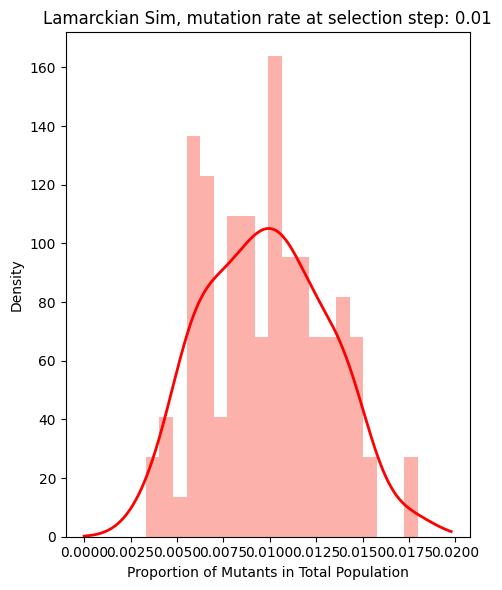

In [21]:
# Lamarckian Results
fig, axs = plt.subplots(1, 1, figsize=(5, 6))
ax_mutants = axs

# Survival is interpreted as mutation, since the 'mutant' proportion i.e. mut at division should be 0
ax_mutants.hist(survival_results_lamarck, bins=20, density=True, alpha=0.6, color="salmon")
ax_mutants.set_xlabel("Proportion of Mutants in Total Population")
ax_mutants.set_ylabel("Density")
ax_mutants.set_title(exp_label)
kde_mutants = stats.gaussian_kde(survival_results_lamarck)
x_mutants = np.linspace(0, max(survival_results_lamarck) * 1.1, 1000)
ax_mutants.plot(x_mutants, kde_mutants(x_mutants), 'r-', lw=2)

plt.tight_layout()

display(Markdown(div_label))
display(Markdown(lifespan_label))

In [7]:
# Param with Darwinian (no mutations until the end) selection
params = {"start_pop_size":10,
            "end_pop_size":1000,
            "division_distribution":"poisson", # gaussian or poisson
            "division_mean":10,
            "division_std":2,
            "division_lambda":10, 
            "mutation_rate":1e-2,  # in lamarckian, this is 0
            "lifespan_distribution":"poisson",  # can do fixed or poisson
            "lifespan":20,
            "lifespan_mean":20,
            "lifespan_std":5,
            "lifespan_lambda":20,
            "base_survival_prob":0,  # in darwinian, this is 0 since mutations must occur before
            "mutation_survival_boost":1.0} # Mutant status again provides no boost since mutations is interpreted as survival


In [8]:
# Parse parameters to string for label
match params["division_distribution"]:
    case "gaussian":
        div_label = rf'Gaussian Division, $\mu={params["division_mean"]}, \sigma={params["division_std"]}$'
    case "poisson":
        div_label = rf'Poisson Division, $\lambda={params["division_lambda"]}$'

match params["lifespan_distribution"]:
    case "gaussian":
        lifespan_label = rf'Gaussian Lifespan, $\mu={params["lifespan_mean"]}, \sigma={params["lifespan_std"]}$'
    case "poisson":
        lifespan_label = rf'Poisson Lifespan, $\lambda={params["lifespan_lambda"]}$'
    case "fixed":
        lifespan_label = rf'Fixed Lifespan = {params["lifespan"]}'

exp_label = rf'Darwinian Sim, mutation rate at selection step: {params["mutation_rate"]}'

In [9]:
# For reference return dict
# "population_size": total_count,
# "mutant_count": mutant_count,
# "mutant_proportion": mutant_proportion,
# "surviving_count": len(surviving_bacteria),
# "survival_proportion": survival_proportion,
# "surviving_mutant_count": surviving_mutant_count,
# "surviving_mutant_proportion": surviving_mutant_proportion,
# "total_divisions": total_divisions,
# "total_mutations": total_mutations,
# "population_history": population_history,
# "mutant_history": mutant_history,
# "final_time": current_time

# All lists
mutant_proportion_darwinian = luria_delbruck_simulation.run_parallel_simulations(params, 100)
survival_results_darwinian = luria_delbruck_simulation.survival_results
# surviving_mutant_results = luria_delbruck_simulation.surviving_mutant_results

Poisson Division, $\lambda=10$

Poisson Lifespan, $\lambda=20$

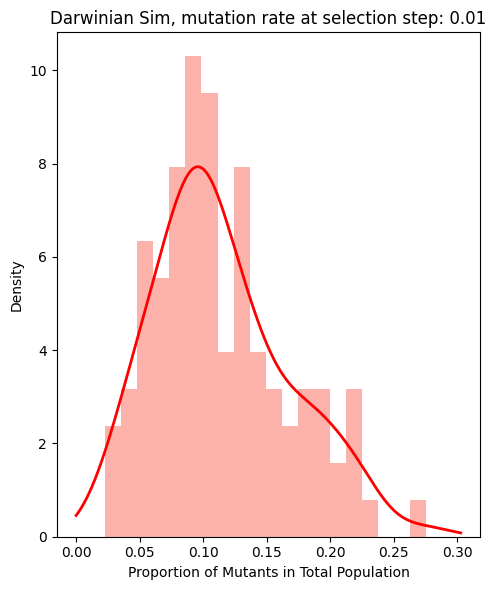

In [10]:
# Lamarckian Results
fig, axs = plt.subplots(1, 1, figsize=(5, 6))
ax_mutants = axs

# Survival is interpreted as mutation, since the 'mutant' proportion i.e. mut at division should be 0
ax_mutants.hist(survival_results_darwinian, bins=20, density=True, alpha=0.6, color="salmon")
ax_mutants.set_xlabel("Proportion of Mutants in Total Population")
ax_mutants.set_ylabel("Density")
ax_mutants.set_title(exp_label)

kde_mutants = stats.gaussian_kde(survival_results_darwinian)
x_mutants = np.linspace(0, max(survival_results_darwinian) * 1.1, 1000)
ax_mutants.plot(x_mutants, kde_mutants(x_mutants), 'r-', lw=2)

plt.tight_layout()

display(Markdown(div_label))
display(Markdown(lifespan_label))

In [22]:
# Param with Darwinian (no mutations until the end) selection
params = {"start_pop_size":10,
            "end_pop_size":1000,
            "division_distribution":"exponential", # gaussian or poisson or exponential
            "division_mean":10,
            "division_std":2,
            "division_lambda":10, 
            "mutation_rate":1e-2,  # in lamarckian, this is 0
            "lifespan_distribution":"exponential",  # can do fixed or poisson or exp
            "lifespan":20,
            "lifespan_mean":20,
            "lifespan_std":5,
            "lifespan_lambda":20,
            "base_survival_prob":0,  # in darwinian, this is 0 since mutations must occur before
            "mutation_survival_boost":1.0} # Mutant status again provides no boost since mutations is interpreted as survival


In [23]:
# Parse parameters to string for label
match params["division_distribution"]:
    case "gaussian":
        div_label = rf'Gaussian Division, $\mu={params["division_mean"]}, \sigma={params["division_std"]}$'
    case "poisson":
        div_label = rf'Poisson Division, $\lambda={params["division_lambda"]}$'
    case "exponential":
        div_label = rf'Exponential Division, $\beta={params["division_mean"]}$'

match params["lifespan_distribution"]:
    case "gaussian":
        lifespan_label = rf'Gaussian Lifespan, $\mu={params["lifespan_mean"]}, \sigma={params["lifespan_std"]}$'
    case "poisson":
        lifespan_label = rf'Poisson Lifespan, $\lambda={params["lifespan_lambda"]}$'
    case "fixed":
        lifespan_label = rf'Fixed Lifespan = {params["lifespan"]}'
    case "exponential":
        lifespan_label = rf'Exponential Lifespan, $\beta={params["lifespan_mean"]}$'

exp_label = rf'Darwinian Longer Life Sim, mutation rate at selection step: {params["mutation_rate"]}'

In [24]:
# For reference return dict
# "population_size": total_count,
# "mutant_count": mutant_count,
# "mutant_proportion": mutant_proportion,
# "surviving_count": len(surviving_bacteria),
# "survival_proportion": survival_proportion,
# "surviving_mutant_count": surviving_mutant_count,
# "surviving_mutant_proportion": surviving_mutant_proportion,
# "total_divisions": total_divisions,
# "total_mutations": total_mutations,
# "population_history": population_history,
# "mutant_history": mutant_history,
# "final_time": current_time

# Return lists
mutant_prop_longer_lifespan_darwinian = luria_delbruck_simulation.run_parallel_simulations(params, 100)
survival_results_longer_lifespan_darwinian = luria_delbruck_simulation.survival_results
# surviving_mutant_results_lamarck = luria_delbruck_simulation.surviving_mutant_results

Exponential Division, $\beta=10$

Exponential Lifespan, $\beta=40$

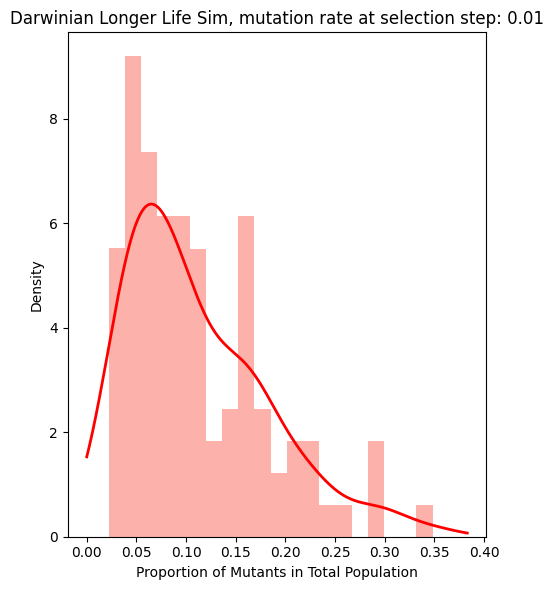

In [14]:
# Lamarckian Results
fig, axs = plt.subplots(1, 1, figsize=(5, 6))
ax_mutants = axs

# Survival is interpreted as mutation, since the 'mutant' proportion i.e. mut at division should be 0
ax_mutants.hist(survival_results_longer_lifespan_darwinian, bins=20, density=True, alpha=0.6, color="salmon")
ax_mutants.set_xlabel("Proportion of Mutants in Total Population")
ax_mutants.set_ylabel("Density")
ax_mutants.set_title(exp_label)

kde_mutants = stats.gaussian_kde(survival_results_longer_lifespan_darwinian)
x_mutants = np.linspace(0, max(survival_results_longer_lifespan_darwinian) * 1.1, 1000)
ax_mutants.plot(x_mutants, kde_mutants(x_mutants), 'r-', lw=2)

plt.tight_layout()

display(Markdown(div_label))
display(Markdown(lifespan_label))